Goal: train, evaluate, and save a single model architecture.

In [1]:
# import statements
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from collections import Counter
import scipy.stats as sp
import itertools

import matplotlib
import matplotlib.font_manager as fm
import os
fpath = '/Library/Fonts/Myriad-Pro_31655.ttf'
prop = fm.FontProperties(fname=fpath)
fname = os.path.split(fpath)[1]
axis_font = {'fontname':fname, 'fontproperties':prop}

# Part 1: Load in data. Filter on QC. 

In [2]:
data_dir = '../../data/'
file_name = 'newQC_toehold_data.csv'
data_df = pd.read_csv(data_dir + file_name,sep=',')
data_df.head(3)

off_id  \
0  AACCAAACACACAAACGCACAAAAAAAAAAAAAAAAAATGGAAAAC...   
1  AACCAAACACACAAACGCACAAAAAAAAAAAAATGGAAAACAGTTA...   
2  AACCAAACACACAAACGCACAAAAAAAAATTACTACTATTGTTAAT...   

                                               on_id source_sequence  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTTAACCAAACACACAAAC...        smallpox   
2  CTAAATTAACAATAGTAGTAATTTTTTTTTAACCAAACACACAAAC...        smallpox   

          sequence_id               pre_seq              promoter  \
0  smallpox_tile_2626  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
1  smallpox_tile_2625  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   
2  smallpox_tile_4951  CTCTGGGCTAACTGTCGCGC  TAATACGACTCACTATAGGG   

                          trigger                 loop1  \
0  AACTGTTTTCCATTTTTTTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
1  TTAGTAACTGTTTTCCATTTTTTTTTTTTT  AACCAAACACACAAACGCAC   
2  CTAAATTAACAATAGTAGTAATTTTTTTTT  AACCAAACACACAAACGCAC   

                           switch        loop2  \
0  AAAAAAAAAAAAAAAAAATGGAAAACAGTT  AACAGAGGAGA   
1  AAAAAAAAAAAAATGGAAAACAGTTACTAA  AACAGAGGAGA   
2  AAAAAAAAATTACTACTATTGTTAATTTAG  AACAGAGGAGA   

                         ...                              stem2  \
0                        ...                          CCATTTTTT   
1                        ...                          GTTTTCCAT   
2                        ...                          CAATAGTAG   

                       linker post_linker  on_value off_value  onoff_value  \
0  AACCTGGCGGCAGCGCAAAAGATGCG  TAAAGGAGAA       NaN  0.333333          NaN   
1  AACCTGGCGGCAGCGCAAAAGATGCG  TAAAGGAGAA       NaN       NaN          NaN   
2  AACCTGGCGGCAGCGCAAAAGATGCG  TAAAGGAGAA  0.068295  0.000000     0.068295   

   on_qc  off_qc  onoff_qc                                    switch_sequence  
0    NaN     NaN       NaN  AAAAAAAAAAAAAAAAAATGGAAAACAGTTAACAGAGGAGAAACTG...  
1    NaN     NaN       NaN  AAAAAAAAAAAAATGGAAAACAGTTACTAAAACAGAGGAGATTAGT...  
2    2.0     1.1       1.1  AAAAAAAAATTACTACTATTGTTAATTTAGAACAGAGGAGACTAAA...  

[3 rows x 22 columns]

In [3]:
qc_cutoff=1.1
data_df = data_df[data_df['on_qc'] >= qc_cutoff].reset_index()
data_df = data_df[data_df['off_qc'] >= qc_cutoff].reset_index()
toehold_seqs = data_df['switch_sequence']
seq_len = len(toehold_seqs[0])
print('Number of remaining sequences: ', len(data_df))

Number of remaining sequences:  91534


In [4]:
# save the pre-downsampling values
pre_downsampling_on = data_df['on_value']
pre_downsampling_off = data_df['off_value']

# Part 2: Downsample data.

In [5]:
on_value_bin_labels = np.arange(1000)
on_value_bins = pd.cut(data_df['on_value'], bins=1000, labels=on_value_bin_labels)
bin_floor_on = math.floor(data_df['on_value'].value_counts(bins=1000).mean())


off_value_bin_labels = np.arange(1000)
off_value_bins = pd.cut(data_df['off_value'], bins=1000, labels=off_value_bin_labels)
bin_floor_off = math.floor(data_df['off_value'].value_counts(bins=1000).mean())

In [6]:
# Going through the 1000 bin counts and preventing no more than 
# the mean number of counts in each bin, then adding all of the indicies
# of the bins to a list for the on and off values
sample_ids_on = []
for bin_label in on_value_bin_labels:
    bin_indices = on_value_bins[on_value_bins == bin_label].index
    bin_num = bin_indices.size
    if bin_num > bin_floor_on:
        sample = np.random.choice(bin_indices, size=bin_floor_on, replace=False)
    else:
        sample = bin_indices
    sample_ids_on.append(sample.tolist())  

sample_ids_off = []
for bin_label in off_value_bin_labels:
    bin_indices = off_value_bins[off_value_bins == bin_label].index
    bin_num = bin_indices.size
    if bin_num > bin_floor_off:
        sample = np.random.choice(bin_indices, size=bin_floor_off, replace=False)
    else:
        sample = bin_indices
    sample_ids_off.append(sample.tolist()) 

In [7]:
# Breaking down list of lists into one list
sample_on = itertools.chain.from_iterable(sample_ids_on)
sample_off = itertools.chain.from_iterable(sample_ids_off)

# take intersection of sample_ids_on and sample_ids_off 
sample_ids_union = set(sample_on).union(sample_off)
sub_df = data_df.loc[sample_ids_union].reset_index(drop=True)

print('New number of remaining seqs:', len(sub_df))

# update parameters to match original (in order to not break later code w/ new sampling)
data_df = sub_df
toehold_seqs = data_df['switch_sequence']

New number of remaining seqs: 81105


In [8]:
# save the post-downsampling values
post_downsampling_on = data_df['on_value']
post_downsampling_off = data_df['off_value']

# Part 3: Plots.

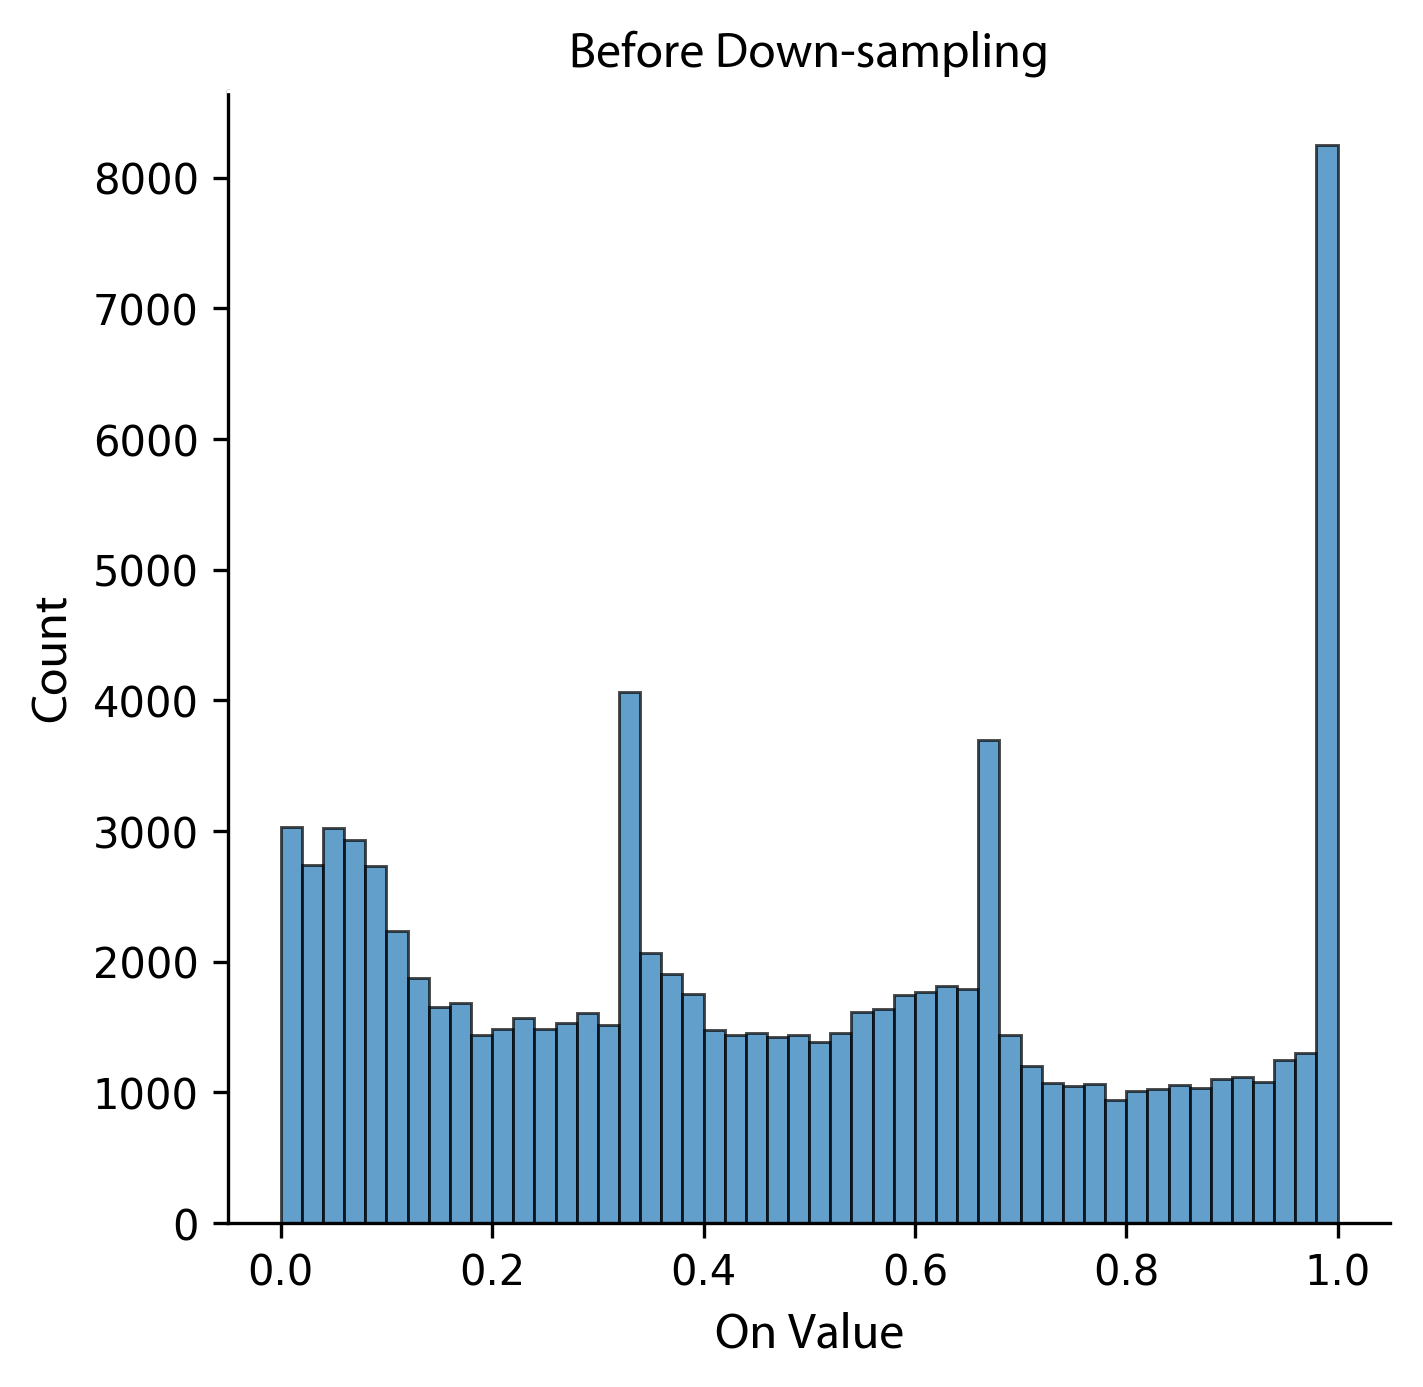

In [9]:
fig, ax = plt.subplots(figsize = (5, 5), dpi = 300)
ax.patch.set_facecolor('white')

num_bins = 50

plt.hist(pre_downsampling_on, bins = num_bins, color = 'tab:blue', edgecolor = 'black', alpha = 0.7, linewidth = 0.7)

plt.xlabel('On Value', **axis_font, fontsize = 12)
plt.ylabel('Count', **axis_font, fontsize = 12)
plt.title('Before Down-sampling', **axis_font, fontsize = 12)

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

#plt.savefig('../../illustrator_files/supp/s11a_on_pre_downsampling.svg')
plt.show()

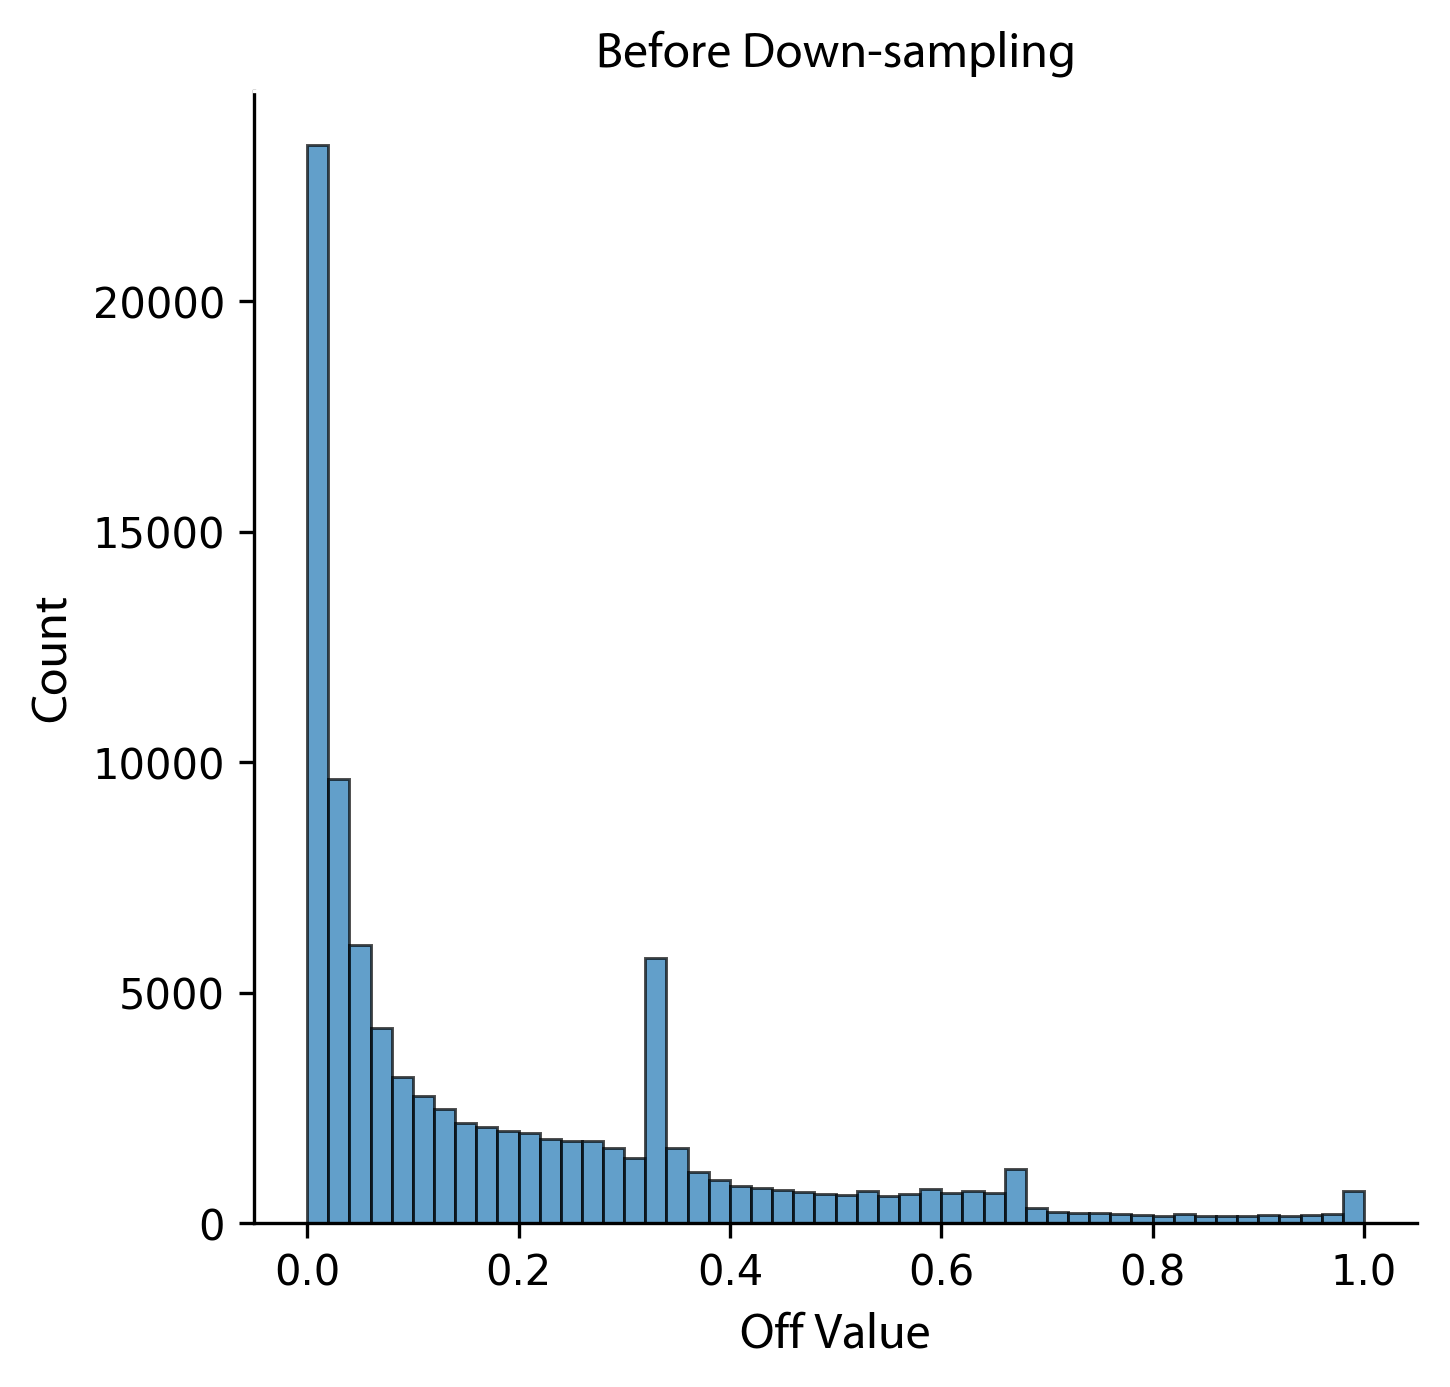

In [10]:
fig, ax = plt.subplots(figsize = (5, 5), dpi = 300)
ax.patch.set_facecolor('white')

num_bins = 50

plt.hist(pre_downsampling_off, bins = num_bins, color = 'tab:blue', edgecolor = 'black', alpha = 0.7, linewidth = 0.7)

plt.xlabel('Off Value', **axis_font, fontsize = 12)
plt.ylabel('Count', **axis_font, fontsize = 12)
plt.title('Before Down-sampling', **axis_font, fontsize = 12)

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

#plt.savefig('../../illustrator_files/supp/s11b_off_pre_downsampling.svg')
plt.show()

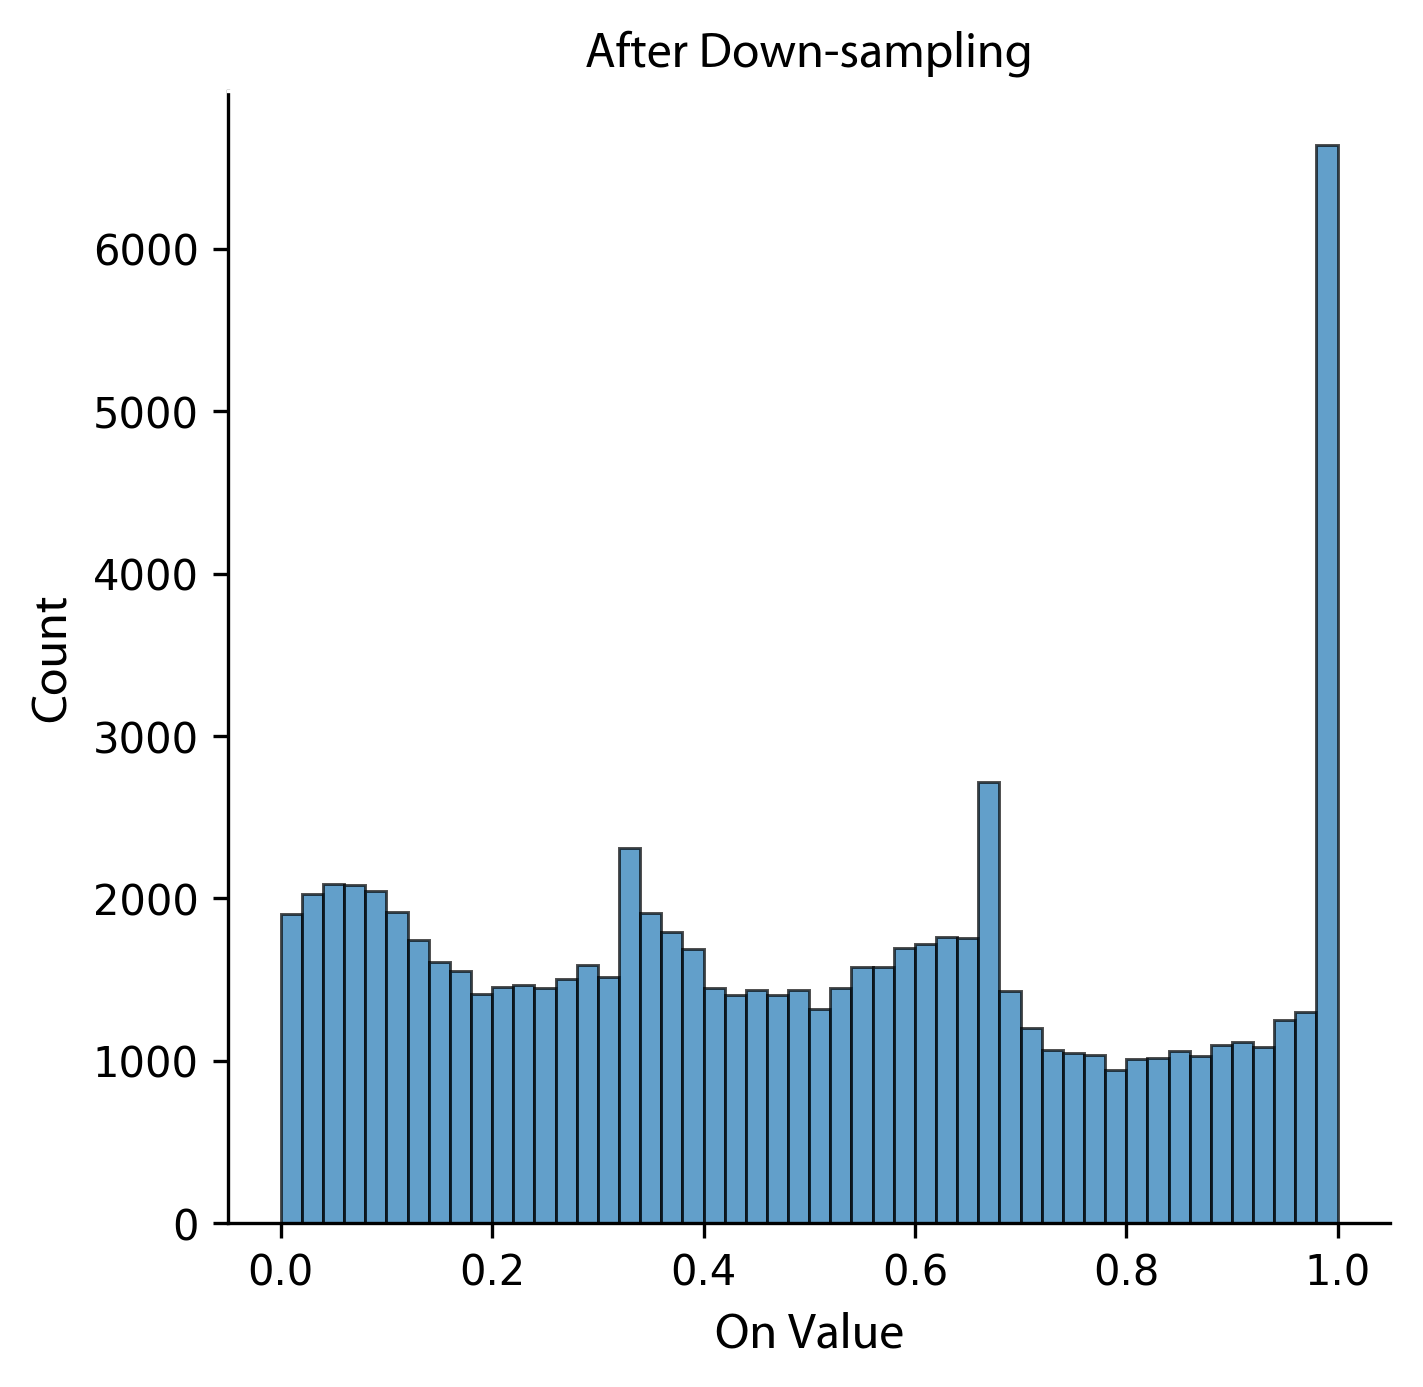

In [11]:
fig, ax = plt.subplots(figsize = (5, 5), dpi = 300)
ax.patch.set_facecolor('white')

num_bins = 50

plt.hist(post_downsampling_on, bins = num_bins, color = 'tab:blue', edgecolor = 'black', alpha = 0.7, linewidth = 0.7)

plt.xlabel('On Value', **axis_font, fontsize = 12)
plt.ylabel('Count', **axis_font, fontsize = 12)
plt.title('After Down-sampling', **axis_font, fontsize = 12)

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

#plt.savefig('../../illustrator_files/supp/s11c_on_post_downsampling.svg')
plt.show()

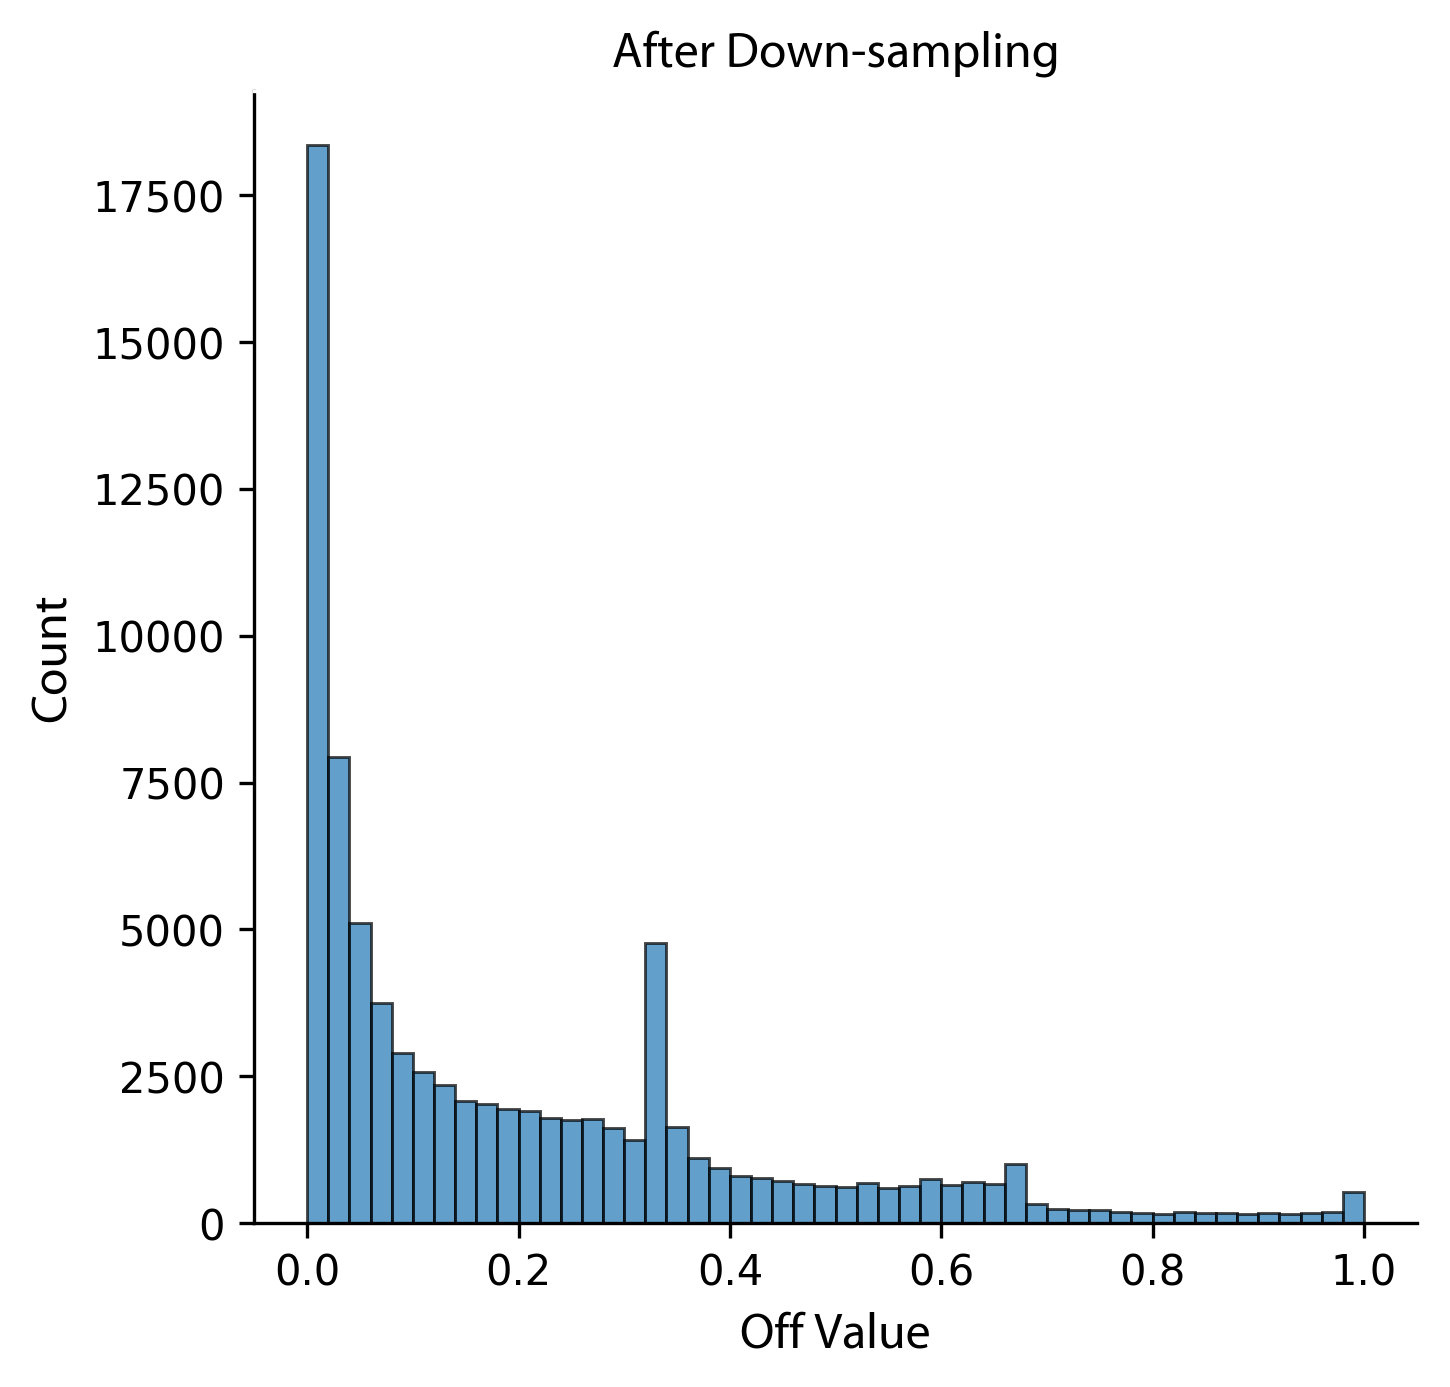

In [12]:
fig, ax = plt.subplots(figsize = (5, 5), dpi = 300)
ax.patch.set_facecolor('white')

num_bins = 50

plt.hist(post_downsampling_off, bins = num_bins, color = 'tab:blue', edgecolor = 'black', alpha = 0.7, linewidth = 0.7)

plt.xlabel('Off Value', **axis_font, fontsize = 12)
plt.ylabel('Count', **axis_font, fontsize = 12)
plt.title('After Down-sampling', **axis_font, fontsize = 12)

ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')

#plt.savefig('../../illustrator_files/supp/s11d_off_post_downsampling.svg')
plt.show()